<a href="https://colab.research.google.com/github/str4w/FaceAndAntiface/blob/main/MaskFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Face Masking
============

Rupert Brooks, March 2025

This notebook uses the segmentation models package and a pretrained backbone to segment a face dataset.  Masks are hand drawn on a small fraction of images in the dataset, and this subset is used to fine tune the segmentation network.  The entire face dataset is segmented and masks saved in the inference section.

If you have already trained a model, or you want to use my provided model, you can jump ahead to the inference section where indicated to use it to segment the entire dataset.

If you just want the resulting masks on the original dataset, these are published on Kaggle here https://www.kaggle.com/datasets/tiredrobot/model-generated-face-masks-for-yapwh-face-data

In [12]:
!pip install -U segmentation-models-pytorch >piplog1.txt
!pip install lightning albumentations >piplog2.txt

In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import time
from datetime import timedelta

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image as tvio_read_image
from torchvision.io import ImageReadMode
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import numpy as np
import PIL
import tqdm
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#device = "cpu"
print(f"Using {device} device")

import kagglehub # for downloading data

Using cpu device


Optional Logins
===============
The Hugging Face login is only required if you want to push a model to the Hugging Face hub.

Letting Colab access your google drive can provide a convenient place to save
checkpoints so they won't be lost if your session times out.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/'My Drive'/data

Mounted at /content/gdrive
A_tale_of_two_cities.100kwords.data.zip  horse2zebra.zip		 mnist_iid_train.h5
CalculatedFaceMasks2.zip		 images				 mnist_noniid_test.h5
CalculatedFaceMasks.zip			 input.txt			 mnist_noniid_train.h5
Coursera				 joual.txt			 multinli_1.0.zip
DLAI					 kaggle_face_data_masks_001.zip  scr_images.zip
Eurosat					 kaggle_face_data_yapwh.zip	 scr_masks.zip
fed_emnist_digitsonly_test.h5		 lear_limericks.csv		 Share_Rupert_Bilinear.zip
fed_emnist_digitsonly_train.h5		 lovecraft.txt			 sollewitt.txt
font_samples				 masktemp.zip			 svhn
fonts.zip				 mnist_iid_test.h5		 Task04_Hippocampus.tar


Download Dataset
================
This face dataset is freely available on Kaggle, and is a downsampled version of this much higher res original.
- Kaggle Version https://www.kaggle.com/datasets/yapwh1208/face-data
- Original https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

As part of this project I hand drew masks on a randomly selected subset of 99 of these images.
- Hand drawn Faces https://www.kaggle.com/datasets/tiredrobot/hand-drawn-face-masks-for-yapwh-face-data

In [2]:
faces_path = kagglehub.dataset_download("yapwh1208/face-data")
print("Faces downloaded to", faces_path)
masks_path = kagglehub.dataset_download("tiredrobot/hand-drawn-face-masks-for-yapwh-face-data")
print("Masks downloaded to", masks_path)


100%|██████████| 49.1M/49.1M [00:00<00:00, 112MB/s] 

Extracting files...


Faces downloaded to /root/.cache/kagglehub/datasets/yapwh1208/face-data/versions/1
Masks downloaded to /root/.cache/kagglehub/datasets/tiredrobot/hand-drawn-face-masks-for-yapwh-face-data/versions/1


In [7]:
def get_face_file_index(faces_path, masks_path, enforce_description=True):
  """Create a dataframe index of face images and masks

  If enforce description is true, reject images where
  age is not between 0 and 120 inclusive, and gender
  is not 0 or 1.
  """
  files = sorted((Path(faces_path) / 'FaceData').glob('*.jpg'))
  # I personally acknowledge the existence of other
  # genders, but this is what the dataset description stated
  gender_lookup={'0':"M", '1':"F"}
  records=[]
  masks = {f.stem: str(f) for f in sorted((Path(masks_path) / '001').glob('*.jpg'))}
  for f in files:
    try:
      age, gender, _ = f.name.split("_", maxsplit=2)
      age=int(age)
      if enforce_description:
        assert age >= 0 and age <= 120, f"Unexpected age {age}"
      if gender in gender_lookup:
        gender = gender_lookup[gender]
      else:
        if enforce_description:
          raise Exception(f"Unexpected gender {gender}")
        else:
          gender = "F" # ¯\_(ツ)_/¯
      mask = masks.get(f.stem)
      if mask:
        mask = str(mask)
      records.append((age, gender, str(f), mask))
    except Exception as e:
      print(f"Error processing {f}")
      print(e)
  df = pd.DataFrame(records, columns=['age', 'gender', 'path', 'mask_path'])
  return df


In [9]:
df = get_face_file_index(faces_path, masks_path, enforce_description=False)
print("Found", len(df), "face files")
print(len(df.query("`mask_path`.notna()")), "have masks")
gender_counts = Counter(df.gender)
print("Gender counts:", [f"{k}: {v}" for k,v in gender_counts.items()])

Found 9780 face files
99 have masks
Gender counts: ['F: 5408', 'M: 4372']


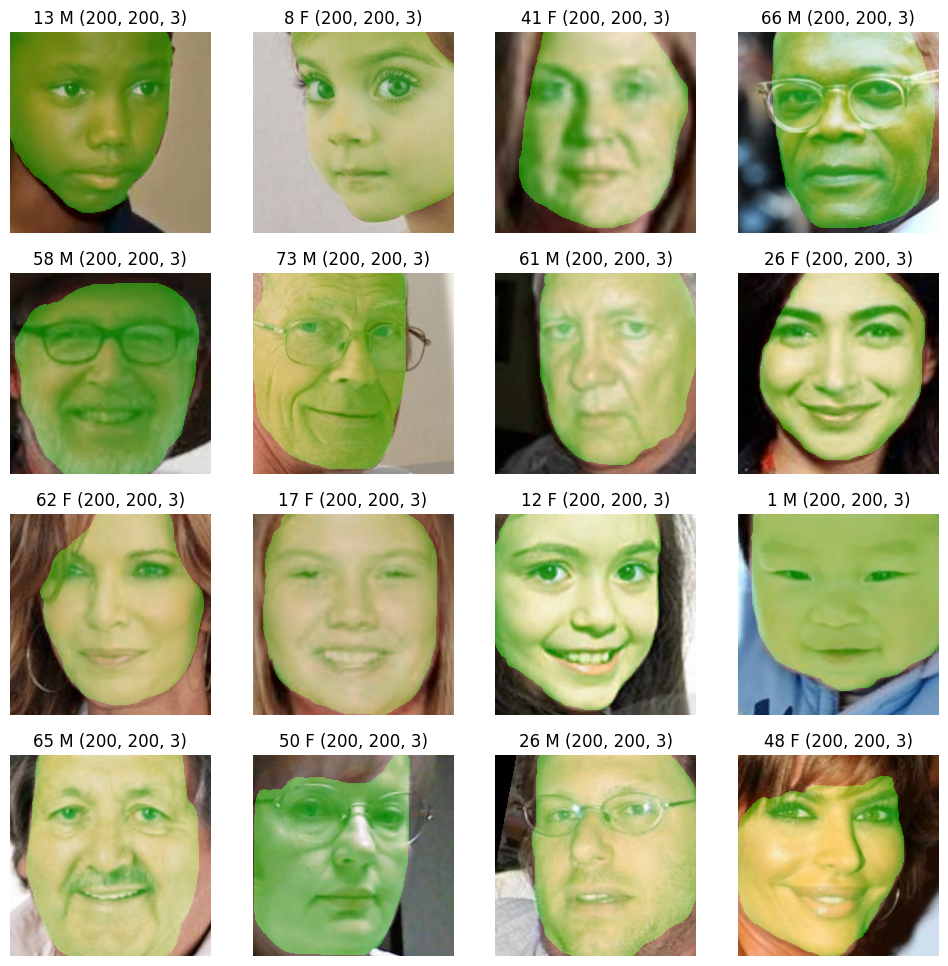

In [10]:
# Take a look at some masked examples
subset = df.query("`mask_path`.notna()").sample(16)
fig, ax = plt.subplots(4,4, figsize=(12,12))
for i in range(4):
  for j in range(4):
    row = subset.iloc[i*4+j]
    z = plt.imread(row.path).copy()
    m = plt.imread(row.mask_path).astype(float) + 0
    m[:,:,0] *=0
    m[:,:,2] *=0
    m = m>m.max()/2
    z[m] = z[m] //2 + (z.max()-z.min())//2

    ax[i,j].imshow(z)
    ax[i,j].set_title(f"{row.age} {row.gender} {z.shape}")
    ax[i,j].axis('off')
#plt.show()

In [11]:
class FaceDataset(Dataset):
    """Masked face dataset"""
    def __init__(self, table, transform=None, target_transform=None):
      self.table = table
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.table)

    def __getitem__(self, idx):
      row = self.table.iloc[idx].to_dict()
      img_path = row["path"]
      mask_path = row["mask_path"]
      image = v2.ToDtype(torch.float32,scale=True)(tvio_read_image(img_path))
      if mask_path:
        mask = tvio_read_image(mask_path)
        mask = v2.ToDtype(torch.float32)(mask[1:2,:,:]>128)
      else:
        mask = torch.zeros((1,image.shape[1],image.shape[2]))
      # apply transform to image and mask together
      if self.transform:
        tmp = torch.stack([image[0],image[1],image[2], mask[0]])
        tmp = self.transform(tmp)
        image = tmp[0:3]
        mask = tmp[3:]
      if self.target_transform:
        mask = self.target_transform(mask)
      return {"image":image, "mask":mask}

Train size: 99 Val size: 16 Test size: 16


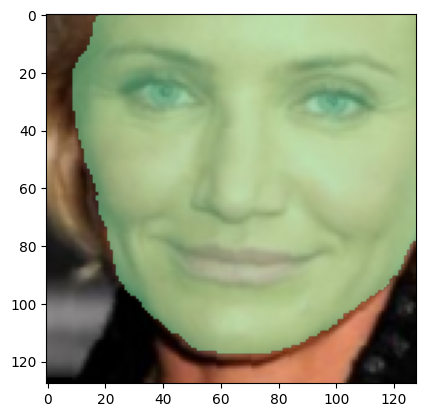

In [14]:
# because we are applying augmentations, the mask may no longer be binary
# binarize it using the Posterize transform.
# We will work at 128 x 128 resolution because the SMP library
# requires divisibility by 32
dtrain = FaceDataset(df.query("`mask_path`.notna()").sample(frac=1, random_state=42),
                     transform=v2.Compose(
                         [
                             v2.RandomHorizontalFlip(),
                             v2.RandomRotation(10),
                             v2.RandomCrop((180,180)),
                             v2.Resize((128,128)),
                         ]),
                     target_transform=v2.RandomPosterize(bits=1,p=1))

test_val = df.query("`mask_path`.isna()").sample(32, random_state=42)

dval = FaceDataset(test_val.iloc[:len(test_val)//2],
                   transform=v2.Resize((128,128)),
                   target_transform=v2.RandomPosterize(bits=1,p=1))
dtest = FaceDataset(test_val.iloc[len(test_val)//2:],
                                         transform=v2.Resize((128,128)),
                     target_transform=v2.RandomPosterize(bits=1, p=1))

print(f"Train size: {len(dtrain)} Val size: {len(dval)} Test size: {len(dtest)}")
z=dtrain[0]
plt.imshow(z["image"].permute(1,2,0))
q = z["mask"].permute(1,2,0).numpy()
q[q==0] = np.nan
plt.imshow(q, alpha=0.5, cmap='rainbow', vmin=0, vmax=1)
plt.show()

Training the model
==================
If doing inference only, you can skip ahead to the inference section.

Note that we've used all the images with masks for training, so the validation and test scores are meaningless.  Terrible practice, but this was really a utility model to bootstrap the 99 hand drawn ones into masks for all.  The validation was by eye.

In [15]:

n_cpu = os.cpu_count()
print("Using", n_cpu, "workers")
train_dataloader = DataLoader(
    dtrain, batch_size=32, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    dval, batch_size=64, shuffle=False, num_workers=n_cpu
)
test_dataloader = DataLoader(
    dtest, batch_size=64, shuffle=False, num_workers=n_cpu
)

Using 2 workers


In [16]:
class FaceModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        for k,v in metrics.items():
          print(f"{k}: {v}")

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        outstr=f"Batch: {batch_idx} Avg Loss: {train_loss_info['loss'].mean()}"
        #for k,v in train_loss_info.items():
        #  outstr += f"{k}: {v} " #.mean():.4f} "
        print(outstr)
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [17]:
# Some training hyperparameters
EPOCHS = 50
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [18]:
model = FaceModel("FPN", "resnet34", in_channels=3, out_classes=1, freeze_encoder=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 240MB/s]


In [19]:
# Note that the directory name here IS the model
# if you want to save multiple versions you have to change the
# directory name.
save_directory="/tmp/SimpleFaceSegmentation"
# alternately, save on google drive
# save_directory="/content/gdrive/My Drive/models/SimpleFaceSegmentation"

In [20]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)
# get original model from lightning FaceModel
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
commit_info = smp_model.save_pretrained(
    save_directory=save_directory,
    push_to_hub=False,  # optional, push model to HF Hub
    #metrics=test_metrics,  # optional, save metrics in model card
    dataset="Faces",  # optional, save dataset name in model card
)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

valid_per_image_iou: 0.0
valid_dataset_iou: 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Batch: 0 Avg Loss: 0.37832993268966675
Batch: 1 Avg Loss: 0.40641480684280396


INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# Push to the Huggingface Hub (must be logged in)
# save in a temp place, but it is the stem of the path here that controls
# the name on HF
temp_save_directory = Path("/tmp") / Path(save_directory).stem
model.save_pretrained(
    save_directory=temp_save_directory,
    push_to_hub=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/92.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/TiredRobot/SimpleFaceSegmentation/commit/8affcc8d47466e5919700e3f2fbbc31802ac8f22', commit_message='Push model using huggingface_hub.', commit_description='', oid='8affcc8d47466e5919700e3f2fbbc31802ac8f22', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TiredRobot/SimpleFaceSegmentation', endpoint='https://huggingface.co', repo_type='model', repo_id='TiredRobot/SimpleFaceSegmentation'), pr_revision=None, pr_num=None)

Inference
=========
Load the model (optional, if you just trained it)

In [ ]:
# load the model from a saved model folder
# (This redownloads the pretrained weights, it is a mixin)
model = smp.from_pretrained(save_directory)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s]


Loading weights from local directory


In [21]:
# Load from Hugging face
model = smp.from_pretrained("TiredRobot/SimpleFaceSegmentation")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/92.7M [00:00<?, ?B/s]

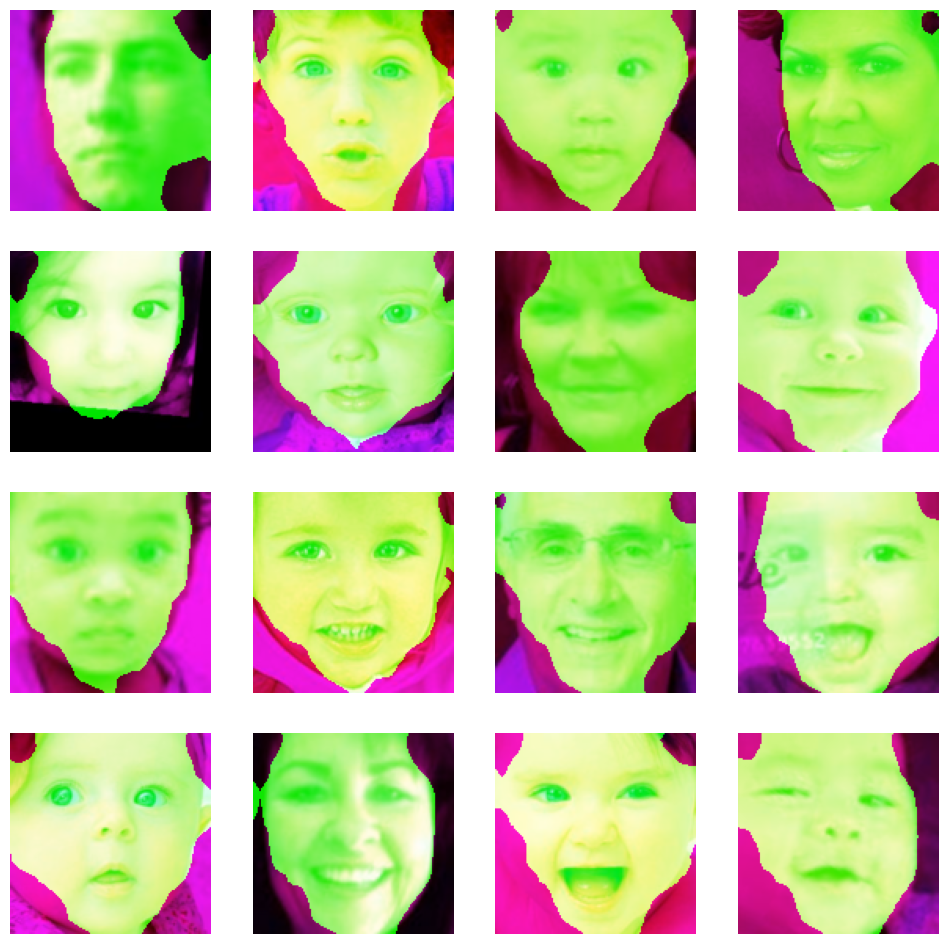

In [22]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()>0.3
fig, ax = plt.subplots(4,4, figsize=(12,12))
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx >= 16:
        break
    image = image.cpu().numpy().transpose(1, 2, 0)
    gt_mask = gt_mask.cpu().numpy().squeeze()
    pr_mask = pr_mask.cpu().numpy().squeeze()
    plt.subplot(4,4, idx+1)
    image = image.clip(0,1)
    image[:,:,1] = image[:,:,1]*0.1 + pr_mask*0.9
    plt.imshow(image)
    plt.axis("off")
plt.show()


In [ ]:
dall = FaceDataset(df,
                  transform=v2.Resize((128,128)),
                  target_transform=v2.RandomPosterize(bits=1, p=1))
!rm -rf CalculatedMasks
!mkdir CalculatedMasks
for i, item in tqdm.tqdm(enumerate(dall)):
  image = item["image"]
  name = Path(df.iloc[i]["path"]).name

  pr_mask = model(image.unsqueeze(0).to(device)).squeeze().detach().cpu()
  pr_mask = pr_mask.sigmoid()>0.3
  mask_pil = PIL.Image.fromarray(pr_mask.numpy().squeeze())
  mask_pil.save(f"CalculatedMasks/{name}")


In [ ]:
!zip -rq "/content/gdrive/My Drive/data/CalculatedFaceMasks3.zip" CalculatedMasks